In [1]:
import scipy as sp
from pyscf import gto, dft, lib, mp, cc, scf, tools, ci, fci

In [2]:
import numpy as np
import sys
sys.path.append( './src/' )

In [3]:
matrix_dot = lambda A, B: np.einsum('ij,ij', A, B)

In [4]:
# H    0.7493682,0.0000000,0.4424329
# O    0.0000000,0.0000000,-0.1653507
# H   -0.7493682,0.0000000,0.4424329

# Define Molecule 

- Note first N atoms will be the ACTIVE portion of the molecule
- the remaining atoms will be the environment

In [113]:
geometry = [
['H@1', (0.7493682,0.0000000,0.4424329)],
['O@1', (0.0000000,0.0000000,-0.1653507)],
    
['H#', (-0.7493682,0.0000000,0.4424329)]
]

# geometry = [
# ['Be@1', (0.0000000,0.0000000,0.0000000)],
# ['H@1', (0.0000000,0.0000000,+1)],
    
# ['H#', (0.0000000,0.0000000,-1)]
# ]

<IPython.core.display.Javascript object>


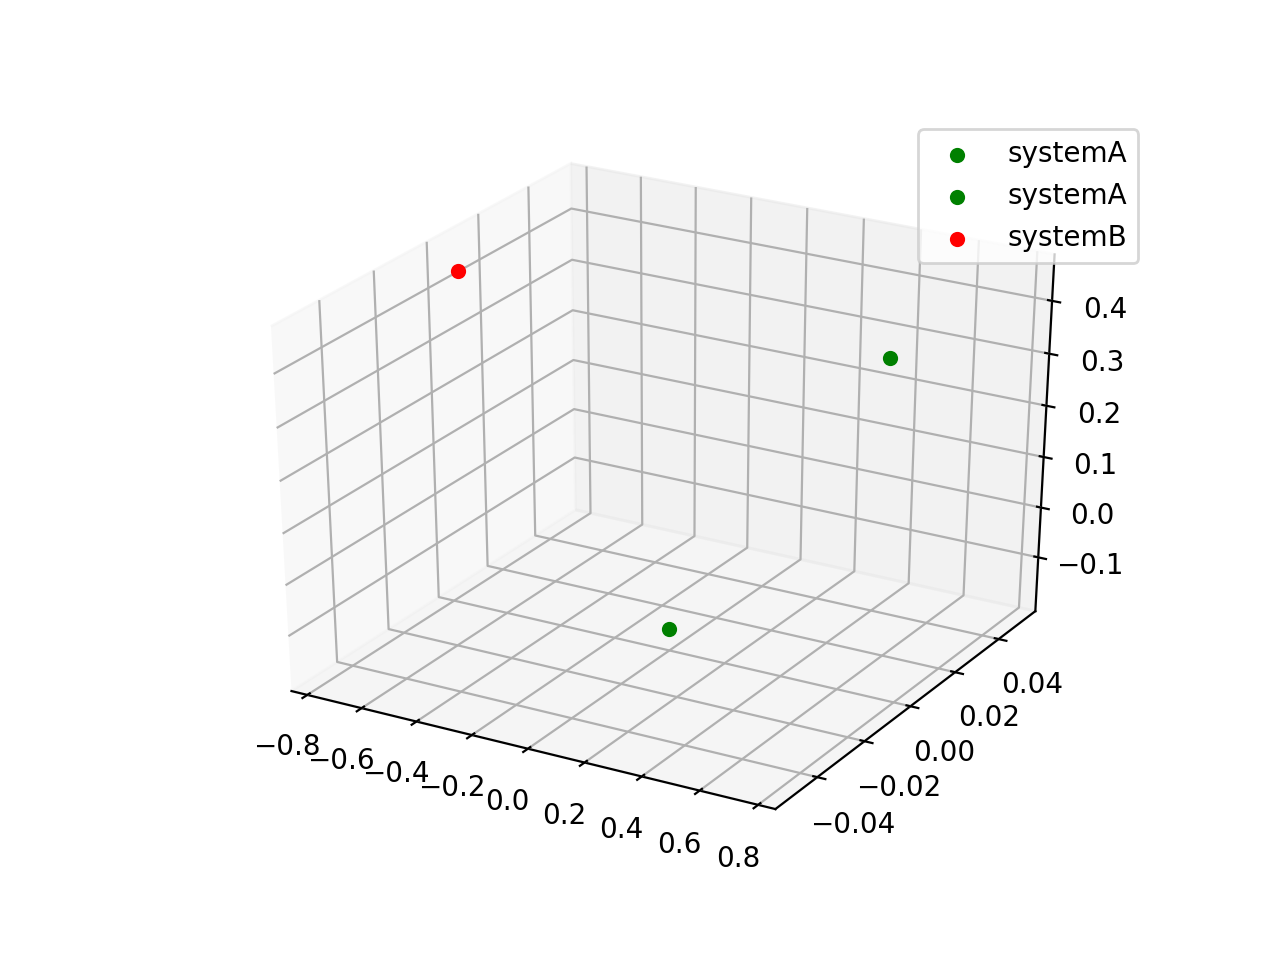

In [114]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*geometry[0][1:][0], marker='o', color='green', label='systemA')
ax.scatter(*geometry[1][1:][0], marker='o', color='green', label='systemA')

for x in range(2, len(geometry)):
    ax.scatter(*geometry[x][1:][0], marker='o', color='red', label='systemB')
plt.legend()
plt.show()


# Define Params

- what level to treat active and envirnoment systems

In [7]:
## define params

basis =  'STO-6G' # '6-31g' #
low_level_xc_functional_or_HF = 'lda, vwn' #'hf'
high_level_xc_functional = 'b3lyp'

low_level_method = 'rhf'
high_level_ref = 'rhf'
high_level_method = 'mp2'

# Build the GLOBAL (full) molecule

In [8]:
full_system_mol = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol.build()
full_system_mol.atom

[['H@1', (0.7493682, 0.0, 0.4424329)],
 ['O@1', (0.0, 0.0, -0.1653507)],
 ['H#', (-0.7493682, 0.0, 0.4424329)]]

In [9]:
full_system_mol.verbose = 1
full_system_mol.max_memory = 8_000 #MB

In [10]:
# import multiprocessing
# from pyscf import lib



# print(lib.num_threads())
# # lib.num_threads(n=multiprocessing.cpu_count())
# # print(lib.num_threads(multiprocessing.cpu_count()))

In [11]:
# help(full_system_mol.unit)

In [12]:
# import os
# # os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())
# os.environ['OMP_NUM_THREADS']

In [13]:
# os.environ["OMP_NUM_THREADS"] 
# # os.environ["OPENBLAS_NUM_THREADS"]

# Run Supersystem Calculation (cheap method)

In [14]:
full_system_scf = scf.RKS(full_system_mol)
full_system_scf.verbose=1
full_system_scf.max_memory= 8_000
full_system_scf.conv_tol = 1e-6
full_system_scf.xc = low_level_xc_functional_or_HF
full_system_scf.kernel()

-75.45216076573017

In [15]:
full_system_scf.e_tot

-75.45216076573017

In [16]:
full_system_scf.conv_check

True

In [17]:
two_e_term_total = full_system_scf.get_veff()
e_xc_total = two_e_term_total.exc
v_xc_total = two_e_term_total - full_system_scf.get_j() 

In [18]:
# full_system_scf.get_fock()
# full_system_scf.get_hcore()

In [19]:
# full_system_scf.mo_coeff

# Run expensive CI calc to compare all results too

In [20]:
HF_scf = scf.RHF(full_system_mol)
HF_scf.verbose=1
HF_scf.max_memory= 8_000
HF_scf.conv_tol = 1e-6
HF_scf.kernel()

my_fci = fci.FCI(HF_scf).run()
print('E(UHF-FCI) = %.12f' % my_fci.e_tot)

# myci = ci.CISD(HF_scf).run() # this is UCISD
# print('UCISD total energy = ', myci.e_tot)

E(UHF-FCI) = -75.731522191956


# Localise orbitals

### Background

The overlap matrix is:

$$S_{\mu \nu} =  \int d\vec{r}_{1} \phi_{\mu}(1)^{*}\phi_{\nu}(1)$$

- $\phi_{\mu}$ are basis functions (defined in basis set)


The unknown molecular orbitals $\psi_{i}$ are expanded as a linear expansion of the $K$ known basis functions:

$$ \psi_{i} =  \sum_{\mu=1}^{K} C_{\mu i} \psi_{\mu}$$


$C$ is a $K \times K$ matrix of expansion coefficients $C_{\mu i}$. The columns of $C$ describe the molecular orbitals!

We can find the total number of electrons $N$ in the system by:

$$ N =  2 \sum_{a}^{N/2}\int d\vec{r}  \bigg( \psi_{a}(\vec{r})^{*} \psi_{i}(\vec{r}) \bigg) =  2 \sum_{a}^{N/2} 1$$

- integral gives probablity of finding electron $a$ over all space (must be 1)
- summing over all electrons will give the total number of electrons

The charge density has the following definition:

$$\rho(\vec{r}) = 2 \sum_{a}^{N/2} \bigg( \psi_{a}(\vec{r})^{*} \psi_{i}(\vec{r}) \bigg)$$

- re-write using definition of $\psi_{i}=  \sum_{\mu=1}^{K} C_{\mu i} \psi_{\mu}$

$$\rho(\vec{r}) = 2 \sum_{a}^{N/2} \Bigg( \bigg[ \sum_{\nu}^{K} C_{\nu a}^{*} \phi_{\nu}(\vec{r})^{*} \bigg] \bigg[ \sum_{\mu}^{K} C_{\mu a}\phi_{\mu}(\vec{r}) \bigg] \Bigg)$$

- move things around

$$\rho(\vec{r}) = \sum_{\nu}^{K} \sum_{\mu}^{K} \Big( 2 \sum_{a}^{N/2} C_{\mu a} C_{\nu a}^{*} \Big) \phi_{\mu}(\vec{r}) \phi_{\nu}(\vec{r})^{*} $$

- which is 

$$\rho(\vec{r}) = \sum_{\mu, \nu}^{K} P_{\mu \nu} \phi_{\mu}(\vec{r}) \phi_{\nu}(\vec{r})^{*} $$


- $P_{\mu \nu}$ is known as the density matrix and is:

$$P_{\mu \nu} = 2 \sum_{a}^{N/2} C_{\mu a} C_{\nu a}^{*}$$

Therefore we can also find the total number of electrons in the system by:

$$ N =  2 \sum_{a}^{N/2}\int d\vec{r}  \bigg( \psi_{a}(\vec{r})^{*} \psi_{i}(\vec{r}) \bigg) =  \sum_{\nu}^{K} \sum_{\mu}^{K} \Big( 2 \sum_{a}^{N/2} C_{\mu a} C_{\nu a}^{*} \Big) \int d\vec{r} \phi_{\mu}(\vec{r})  \phi_{\nu}(\vec{r})^{*}$$

- This is simply:

$$N =  \sum_{\nu}^{K} \sum_{\mu}^{K} P_{\mu \nu} S_{\nu \mu}$$

- in an orthognal basis $S$ should be the identity matrix (as it is overlap of matrix of orthogonal orbs), SO WE GET:

$$N =  \sum_{\nu}^{K} \sum_{\mu}^{K} P_{\mu \nu} S_{\nu \mu} = \sum_{\mu}^{K} PS_{\mu \mu} = \mathcal{Tr}(PS)$$

In [21]:
S_mat = full_system_scf.get_ovlp()
print(np.around(S_mat))

[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -0.  0.]
 [ 0.  0.  0.  1.  0.  0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. -0.  0.  0.  1.  0.]
 [ 0.  0.  0. -0.  0.  0.  1.]]


- One can interpret $ PS_{\mu \mu}$ in the above equation as the number of electrons associated with $ \phi_{\mu}$
- This is a **Mulliken population analysis**

# Orbital Localization!

In [22]:
from pyscf import lo

A molecular orbital is usually delocalized, i.e. it has non-negligible amplitude over the whole system rather than only around some atom(s) or bond(s). However, one can choose a unitary rotation 

- When we perform a SCF calculation, one gets an optimized C matrix
    - $C$ is a $K \times K$ matrix of expansion coefficients $C_{\mu i}$
    - The columns of $C$ describe the molecular orbitals!
    - MO i: $ \psi_{i} =  \sum_{\mu=1}^{K} C_{\mu i} \psi_{\mu}$
    
    
- These molecular orbitals are usually **delocalized**
    - non-negligible amplitude over the whole system, rather than only around some atom(s) or bond(s)

- But we know in QM that a given basis choice is NOT unique


- We can therefore perform a unitary rotation on molecular orbitals

$$ \psi_{i} U_{rot} =  \Big( \sum_{\mu=1}^{K} C_{\mu i} \psi_{\mu} \Big) U_{rot} = \psi_{i}^{new}$$
    
    
The idea is to use a rotation such that the resulting orbitals $\psi_{i}^{new}$ are as spatially localized as possible. 


The Pipek-Mezey (PM) [localization](https://notendur.hi.is/hj/papers/paperPipekmezey8.pdf) **maximizes the population charges on the atoms**:

$$ f (U_{rot}) = \sum_{A}^{N_{atoms}} \Bigg( Z_{A} -  \sum_{\mu \text{ on atom } A} PS_{\mu \mu} \Bigg)$$

In [23]:
# Take occupied orbitals of global system calc
occ_orbs = full_system_scf.mo_coeff[:,full_system_scf.mo_occ>0]

# run localization scheme
PM = lo.PipekMezey(full_system_mol, occ_orbs)
PM.pop_method = 'mulliken' # 'meta-lowdin', 'iao', 'becke'
C_mull = PM.kernel()

C_loc_occ = PM.mo_coeff # <-- these are the NEW C matrix (where orbitals are localized to atoms)

In [24]:
np.array_equal(C_mull, C_loc_occ)

True

In [25]:
## check number of electrons is still the same 
# should be the same after change of basis has been done

dm_localised = 2* C_loc_occ @ C_loc_occ.conj().T
S = full_system_scf.get_ovlp()

print(np.isclose(np.trace(dm_localised@S), full_system_mol.nelectron))

True


# Choose active and environment systems

## METHOD 1 

- Given optimized $C$ coefficient matrix
    - which has been rotated to localize orbitals
    - (used to build localized density matrix)


- **Look through basis functions $\phi_{\mu}$ of the ACTIVE atoms**
    
    
- check the mulliken charge // mulliken population of the orbital
    - if above a certain threshold associate it to active system
    - otherwise put in the environment

In [26]:
## pyscf notes

# order of atoms in geometry is important
full_system_mol.atom

[['H@1', (0.7493682, 0.0, 0.4424329)],
 ['O@1', (0.0, 0.0, -0.1653507)],
 ['H#', (-0.7493682, 0.0, 0.4424329)]]

In [27]:
# aoslice_by_atom gives a matrix:
full_system_mol.aoslice_by_atom()

# where rows are defined by atoms (given by order in full_system_mol.atom - see cell above)
# the 3rd column gives first basis function index for THAT atom
# the last(4th) column gives the last basis function index for THAT atom

array([[0, 1, 0, 1],
       [1, 4, 1, 6],
       [4, 5, 6, 7]])

Therefore loop over basis function centered on the active atoms and find mulliken charge // population

In [28]:
# https://pubs.acs.org/doi/pdf/10.1021/ct300544e
# paper states there are 5 active orbs... where mulliken_population threshold set to 0.4
# here I get the result if threshold set to 0.9

# NOTE in molecule the active atoms must be listed FIRST!

THRESHOLD = 1.5
AO_slice_matrix = full_system_mol.aoslice_by_atom()
N_active_atoms = 2

active_ao_ind=[]

PS_matrix = dm_localised @ S
atomic_charges_list = full_system_mol.atom_charges()
for atm_i, atm_str in enumerate([atom_str for atom_str, _ in full_system_mol.atom][:N_active_atoms]):
    slice_ind = list(range(AO_slice_matrix[atm_i, 2], AO_slice_matrix[atm_i, 3]))
    
    print(atm_str)
    qA = atomic_charges_list[atm_i] #atomic charge of atom_i
    for mu in slice_ind:
        mulliken_charge = qA - PS_matrix[mu,mu]  # mulliken charge of ao centred on atom_i
        mulliken_population = PS_matrix[mu,mu]  # mulliken pop of ao centred on atom_i
#         print(mulliken_charge)
        print(mulliken_population)
        if mulliken_population>THRESHOLD: ### <--- not sure about this THRESHOLD
            active_ao_ind.append(mu)
        
    print('###')

active_ao_ind

H@1
0.8046412946330878
###
O@1
1.9979534425060614
1.8638804129922752
1.0979770385588599
1.9999999999999998
1.4309065166766268
###


[1, 2, 4]

In [29]:
# assign the rest of the missing indices to the environment

enviro_ao_ind = [ind for ind in range(C_loc_occ.shape[1]) if ind not in active_ao_ind]
enviro_ao_ind

[0, 3]

In [30]:
full_system_mol.aoslice_nr_by_atom()[1][3]

6

## METHOD 2 - SPADE

In [31]:
###### SPADE

# Take occupied orbitals of global system calc
occ_orbs = full_system_scf.mo_coeff[:,full_system_scf.mo_occ>0]


N_active_AO = AO_slice_matrix[N_active_atoms-1][3]  # find max AO index for active atoms (neg 1 as python indexs from 0)

orthogonal_orbitals = occ_orbs[:N_active_AO, :] # take active rows and all columns

u, singular_values, rotation_matrix = np.linalg.svd(orthogonal_orbitals, full_matrices=True)

# find where largest step change 
delta_s = [(i, (singular_values[i] - singular_values[i+1] )) for i in range(len(singular_values) - 1)] # contains (index, delta_s)
n_act_mos = max(delta_s, key=lambda x: x[0])[0] + 1 # finds index where largest step change is! (adds 1 for python indexing)
n_env_mos = len(singular_values) - n_act_mos

###
# next rotate orbtials using SVD rotation - selecting active and enironment portions

In [32]:
# localization = 'SPADE'
localization = 'PM_loc'

if localization == 'SPADE':
    
    # next rotate occupied orbitals of global system calc (NOT localized)
    # using SVD rotation - selecting active and enironment portions
    
    act_orbitals = occ_orbs @ rotation_matrix.T[:, :n_act_mos]
    env_orbitals = occ_orbs @ rotation_matrix.T[:, n_act_mos:]
    
    GLOBAL_rotated_orbitals = occ_orbs @ rotation_matrix.T
    
    dm_active =  2 * act_orbitals @ act_orbitals.T
    dm_enviro =  2 * env_orbitals @ env_orbitals.T
    
    active_ao_ind = list(range(n_act_mos))
    enviro_ao_ind = list(range(n_act_mos, len(singular_values)))
    
elif  localization == 'PM_loc':
    
    # take active and envirnoment orbs from LOCALIZED ORBITALS
    act_orbitals = C_loc_occ[:, active_ao_ind]
    env_orbitals = C_loc_occ[:, enviro_ao_ind]
    
    GLOBAL_rotated_orbitals = C_loc_occ
    
    n_act_mos = len(active_ao_ind)
    n_env_mos = len(enviro_ao_ind) # full_system_mol.aoslice_by_atom()[-1,-1] - n_act_mos

    dm_active =  2 * act_orbitals @ act_orbitals.T
    dm_enviro =  2 * env_orbitals @ env_orbitals.T
    
print(f'number of e- in system = {full_system_mol.nelectron}')
print('number of e- in subsystems:', np.trace(dm_active@S) + np.trace(dm_enviro@S))

number of e- in system = 10
number of e- in subsystems: 9.999999999999996


In [33]:
# checking denisty matrix parition makes sense:

# gamma_rotated_FULL = gamma_act_rotated + gamma_env_rotated
dm_act_and_env = 2* GLOBAL_rotated_orbitals@ GLOBAL_rotated_orbitals.conj().T
np.allclose(dm_active+dm_enviro, dm_act_and_env)

True

# Save orbitals to view

Save localized orbitals as molden file

(allowing MOs to be viewed, to see if localization makes sense)

open with: https://avogadro.cc/

In [34]:
with open('LOCALIZED_orbs.molden', 'w') as outfile:
    tools.molden.header(full_system_mol, outfile)
    tools.molden.orbital_coeff(
                        full_system_mol,
                         outfile, 
                         act_orbitals, # <- active orbitals!
                         ene=full_system_scf.mo_energy[np.array(active_ao_ind)],
                         occ=full_system_scf.mo_occ[np.array(active_ao_ind)])

In [35]:
########################## mulliken pop check START

In [36]:
# https://github.com/pyscf/pyscf/blob/master/pyscf/scf/hf.py

Mulliken_population = np.einsum('ij,ji->i', dm_localised, S).real
Mulliken_population

array([0.80464129, 1.99795344, 1.86388041, 1.09797704, 2.        ,
       1.43090652, 0.80464129])

In [37]:
mulliken_charges = np.zeros(full_system_mol.natm)
for i, s in enumerate(full_system_mol.ao_labels(fmt=None)):
    mulliken_charges[s[0]] += Mulliken_population[i]
mulliken_charges = full_system_mol.atom_charges() - mulliken_charges
mulliken_charges

array([ 0.19535871, -0.39071741,  0.19535871])

In [38]:
full_system_mol.mulliken_pop(dm=dm_localised)

 ** Mulliken pop  **
pop of  0 H@1 1s        0.80464
pop of  1 O@1 1s        1.99795
pop of  1 O@1 2s        1.86388
pop of  1 O@1 2px       1.09798
pop of  1 O@1 2py       2.00000
pop of  1 O@1 2pz       1.43091
pop of  2 H# 1s        0.80464
 ** Mulliken atomic charges  **
charge of  0H@1 =      0.19536
charge of  1O@1 =     -0.39072
charge of  2H# =      0.19536


(array([0.80464129, 1.99795344, 1.86388041, 1.09797704, 2.        ,
        1.43090652, 0.80464129]),
 array([ 0.19535871, -0.39071741,  0.19535871]))

In [39]:
########################z## mulliken pop check END

# Embedding

In [40]:
#It seems that PySCF lumps J and K in the J array 
J_act = full_system_scf.get_j(dm = dm_active)
K_act = np.zeros_like(J_act)
two_e_term_act =  full_system_scf.get_veff(dm=dm_active)
e_xc_act = two_e_term_act.exc
v_xc_act = two_e_term_act - J_act 

E_act = np.einsum('ij, ij', dm_active, full_system_scf.get_hcore() + J_act/2) + e_xc_act
E_act

-32.21457910375053

In [41]:
full_system_scf.energy_elec(dm=dm_active)[0]

-32.21457910375052

In [42]:
#It seems that PySCF lumps J and K in the J array 
J_env = full_system_scf.get_j(dm = dm_enviro)
K_env = np.zeros_like(J_env)
two_e_term_env =  full_system_scf.get_veff(dm=dm_enviro)
e_xc_env = two_e_term_env.exc
v_xc_env = two_e_term_env - J_env 

E_env = np.einsum('ij, ij', dm_enviro, full_system_scf.get_hcore() + J_env/2) + e_xc_env
E_env

-70.97624254622325

In [43]:
full_system_scf.energy_elec(dm=dm_enviro)[0]

-70.97624254622326

In [44]:
j_cross = 0.5 * (matrix_dot(dm_active, J_env) + matrix_dot(dm_enviro, J_act))
k_cross = 0.0

In [45]:
xc_cross = e_xc_total - e_xc_act - e_xc_env
two_e_cross = j_cross + k_cross + xc_cross

# Define projection method

In [46]:
projector_method = 'huzinaga'
# projector_method = 'mu_shfit'

if projector_method == 'huzinaga':
    Fock = full_system_scf.get_hcore() + full_system_scf.get_veff(dm=dm_act_and_env)
    F_gammaB_S = Fock @ dm_enviro @ S
    projector = -0.5 * (F_gammaB_S + F_gammaB_S.T)
elif projector_method == 'mu_shfit':
    mu = 1e6
    projector = mu * (S @ dm_enviro  @ S)
else:
    raise ValueError(f'Unknown projection method {projector_method}')



# Define the embbed matrix

$$h^{A_{\text{act}} \text{ in } B_{\text{env}}} = h^{\text{core}} + v^{\text{embed}}$$

$$v^{\text{embed}} = g[\gamma^{A_{\text{act}}} + \gamma^{B_{\text{env}}} ] - g[\gamma^{A_{\text{act}}}] + P_{\text{projector}}$$

In [47]:
# define the embedded term
g_A_and_B = full_system_scf.get_veff(dm=dm_active+dm_enviro)

g_A = full_system_scf.get_veff(dm=dm_active)

v_emb = g_A_and_B - g_A + projector

In [48]:
# PsiEmbed definition
v_emb2 = (J_env + v_xc_total - v_xc_act + projector)

In [49]:
# check these are the SAME!
np.allclose(v_emb, v_emb2)

True

note $P$ is a projection operator that **enforces intersubsystem orbital orthogonality.**

# Next find optimized $\gamma^{A_{\text{act}}}_\text{embedded}$

- this is done by running SCF calc using embedded $h^{A_{\text{act}} \text{ in } B_{\text{env}}}$

Steps:

1. Define full molecular system
2. Change the number of electrons to be the same number as active system allows
3. run SCF to get optimized electron density!

TODO: Could maybe calculate $\gamma^{A_{\text{act}}}_\text{embedded}$ using high level method!

In [50]:
full_system_mol_EMBEDDED = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_EMBEDDED.build()

# RE-DEFINE number of electrons in system
full_system_mol_EMBEDDED.nelectron = 2*len(active_ao_ind)

EMBEDDED_full_system_scf = scf.RKS(full_system_mol_EMBEDDED)
EMBEDDED_full_system_scf.verbose=1
EMBEDDED_full_system_scf.max_memory= 8_000
EMBEDDED_full_system_scf.conv_tol = 1e-6
EMBEDDED_full_system_scf.xc = low_level_xc_functional_or_HF

h_core = EMBEDDED_full_system_scf.get_hcore()

# overwrite h_core to include embedding term!!!!
EMBEDDED_full_system_scf.get_hcore = lambda *args: v_emb + h_core


EMBEDDED_full_system_scf.kernel()

-4.271063112821885

In [51]:
EMBEDDED_full_system_scf.conv_check

True

# Get optimized $\gamma^{A_{\text{act}}}_\text{embedded}$

In [52]:


EMBEDDED_occ_orbs = EMBEDDED_full_system_scf.mo_coeff[:,EMBEDDED_full_system_scf.mo_occ>0]

# optimized embedded denisty matrix
density_emb = 2 * EMBEDDED_occ_orbs @ EMBEDDED_occ_orbs.conj().T

## check number of electrons makes sense:
np.isclose(np.trace(density_emb@S), 2*len(active_ao_ind))

True

# Calculate Energy

The energy can be found according too:

$$E[\gamma^{A_{\text{act}}}_\text{embedded}; \; \; \gamma^{A_{\text{act}}},\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]
= \mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}] + E[\gamma^{B_{\text{env}}}] + g[\gamma^{A_{\text{act}}}, \gamma^{B_{\text{env}}}] + \mathcal{Trace}\big[(\gamma^{A_{\text{act}}}_\text{embedded}-\gamma^{A_{\text{act}}})(h^{A_{\text{act}} \text{ in } B_{\text{env}}} - h )\big]$$



- $\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]$
    - energy of isolated A computed with new optimized embedded density matrix
    - Note this allows for applicaton of different fucntionals (hence why odd E used)
- $E[\gamma^{B_{\text{env}}}]$ DFT calc of isolated subsystem B
- $g[\gamma^{A_{\text{act}}}, \gamma^{B_{\text{env}}}]$ non additive energy (boundary condition) between subsystems
    - this is obtained from global calc!
- Trace term provides a first order correction to the energy!

$\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]$

In [53]:
J_emb, K_emb =EMBEDDED_full_system_scf.get_jk(dm=density_emb) 

# NOTE how normal H_core is being used!
e_act_emb = matrix_dot(density_emb, h_core + 0.5 * J_emb - 0.25 * K_emb)
e_act_emb

-31.955332647953597

In [54]:
# Test this with STANDARD full system obj
# (changing density matrix for embedded one)
J_test, K_test = full_system_scf.get_jk(dm=density_emb)

np.allclose(J_emb, J_test) and np.allclose(K_emb, K_test)

True

In [55]:
# should be able to calculate energy in the same fashion
# using STANDARD full system obj and new embedded density matrix

# THIS METHOD IS BETTER THAN ABOVE (matches energy of global calc now!!!!)

e_act_emb = full_system_scf.energy_elec(dm=density_emb)[0]
e_act_emb

-32.21432253370418

In [56]:
# note this is WRONG
EMBEDDED_full_system_scf.energy_elec(dm=density_emb)
# it is uses EMBEDDED h_core

(-13.399346841104823, 9.312996250279216)

Note for

$$\mathcal{Trace}\big[(\gamma^{A_{\text{act}}}_\text{embedded}-\gamma^{A_{\text{act}}})(h^{A_{\text{act}} \text{ in } B_{\text{env}}} - h )\big]$$


- as : $h^{A_{\text{act}} \text{ in } B_{\text{env}}} = h^{\text{core}} + v^{\text{embed}}$
- we can re-write the first order correction as:

$$\mathcal{Trace}\big[(\gamma^{A_{\text{act}}}_\text{embedded}-\gamma^{A_{\text{act}}})(h^{A_{\text{act}} \text{ in } B_{\text{env}}} - h )\big] = \mathcal{Trace}\big[(\gamma^{A_{\text{act}}}_\text{embedded}-\gamma^{A_{\text{act}}})(v^{\text{embed}})\big]$$

In [57]:
correction = (matrix_dot(v_emb, density_emb - dm_active))
correction

-0.00025656610634293376

In [58]:
e_mf_emb = e_act_emb + E_env + two_e_cross + full_system_scf.energy_nuc() + correction
e_mf_emb # <-- energy from embedded DFT calc

-75.4521607617902

In [59]:
full_system_scf.e_tot # <-- energy from normal DFT calc

-75.45216076573017

In [60]:
my_fci.e_tot # <-- energy from CI calc

-75.73152219195629

## higher level DFT calc

- we can calculate $\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]$ using a better functional

In [61]:
full_system_mol_HIGH_LEVEL_DFT = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_HIGH_LEVEL_DFT.build()

full_system_scf_HIGH_LEVEL = scf.RKS(full_system_mol_HIGH_LEVEL_DFT)
full_system_scf_HIGH_LEVEL.verbose=1
full_system_scf_HIGH_LEVEL.max_memory= 8_000
full_system_scf_HIGH_LEVEL.conv_tol = 1e-6
full_system_scf_HIGH_LEVEL.xc = high_level_xc_functional # <-- BETTER functional!
# full_system_scf_HIGH_LEVEL.kernel()

In [62]:
e_act_emb_HIGH_LVL = full_system_scf_HIGH_LEVEL.energy_elec(dm=density_emb)
e_act_emb_HIGH_LVL # run energy calc using high level functional (note density matrix is embedded A)

(-32.273088426752, 9.254230357248403)

In [63]:
e_act_emb_HIGH_LVL[0]

-32.273088426752

In [64]:
E_high_lvl_DFT = e_act_emb_HIGH_LVL[0] + E_env + two_e_cross + full_system_scf.energy_nuc() + correction
E_high_lvl_DFT # <-- energy from embedded DFT calc

-75.51092665483802

In [65]:
print('High level DFT in DFT error:', np.abs(E_high_lvl_DFT-my_fci.e_tot))

print('LOW level DFT in DFT error:', np.abs(e_mf_emb-my_fci.e_tot))

High level DFT in DFT error: 0.22059553711827107
LOW level DFT in DFT error: 0.27936143016609094


# Perform high level WaveFunction calc

- we can calculate $\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]$ using Wf methods now

# WF calculation

1. Perform HF calc using embedded Hcore to find gamma_act_emb

In [66]:
full_system_mol_EMBEDDED_HF = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_EMBEDDED_HF.build()

# RE-DEFINE number of electrons in system
full_system_mol_EMBEDDED_HF.nelectron = 2*len(active_ao_ind)

EMBEDDED_full_system_scf_HF = scf.RHF(full_system_mol_EMBEDDED)
EMBEDDED_full_system_scf_HF.verbose=1
EMBEDDED_full_system_scf_HF.max_memory= 8_000
EMBEDDED_full_system_scf_HF.conv_tol = 1e-6
# EMBEDDED_full_system_scf_HF.xc = low_level_xc_functional_or_HF

h_core = EMBEDDED_full_system_scf_HF.get_hcore()

# overwrite h_core to include embedding term!!!!
EMBEDDED_full_system_scf_HF.get_hcore = lambda *args: v_emb + h_core


EMBEDDED_full_system_scf_HF.kernel()

-4.030044972631652

In [67]:
EMBEDDED_full_system_scf_HF.conv_check

True

In [68]:
EMBEDDED_occ_orbs_HF = EMBEDDED_full_system_scf_HF.mo_coeff[:,EMBEDDED_full_system_scf_HF.mo_occ>0]

# optimized embedded denisty matrix
density_emb_HF = 2 * EMBEDDED_occ_orbs_HF @ EMBEDDED_occ_orbs_HF.conj().T

## check number of electrons makes sense:
np.isclose(np.trace(density_emb_HF@S), 2*len(active_ao_ind))

True

In [69]:
e_hf_check = EMBEDDED_full_system_scf_HF.energy_tot(dm=density_emb_HF, 
                                         vhf=EMBEDDED_full_system_scf_HF.get_veff())
e_hf_check

-4.030044972631652

# Next

2. Run WF method using embedded h_core

In [70]:
embedded_cc_obj = cc.CCSD(EMBEDDED_full_system_scf_HF)

embedded_cc_obj.nocc = EMBEDDED_full_system_scf_HF.mol.nelectron // 2
embedded_cc_obj.nmo = EMBEDDED_full_system_scf_HF.mo_energy.size
# NEED to redefine embedded h_core again!
embedded_cc_obj._scf.get_hcore = lambda *args: v_emb + h_core
e_cc, t1, t2 = embedded_cc_obj.kernel()

E(CCSD) = -4.100672312551892  E_corr = -0.07062733992024073


In [71]:
embedded_cc_obj = cc.CCSD(EMBEDDED_full_system_scf_HF)

# NEED to redefine embedded h_core again!
embedded_cc_obj._scf.get_hcore = lambda *args: v_emb + h_core
e_cc, t1, t2 = embedded_cc_obj.kernel()

E(CCSD) = -4.100672312551892  E_corr = -0.07062733992024073


In [72]:
np.isclose(embedded_cc_obj.e_hf,e_hf_check) # check HF and CC_hf match!

True

In [73]:
C_wf = embedded_cc_obj.mo_coeff[:,EMBEDDED_full_system_scf_HF.mo_occ>0] # take occupied C_coeff

dm_wf = 2* C_wf @ C_wf.conj().T # THIS is embedded dm matrix from cc calc!
np.isclose(np.trace(dm_wf@S), 2*len(active_ao_ind))

True

In [74]:
# check everything makes sense:
embedded_cc_obj.e_tot == EMBEDDED_full_system_scf_HF.energy_tot(dm=dm_wf) + e_cc

True

In [75]:
WF_correction = (matrix_dot(v_emb, dm_wf - dm_active))
WF_correction

-0.019701888553904784

# Finally
3. Run everything again, using optimized embedded density matrix using standard system obj!

In [76]:
full_system_mol_HF_normal_obj = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_HF_normal_obj.build()

# redefine number of electrons in system
full_system_mol_HF_normal_obj.nelectron = 2*len(active_ao_ind)

full_system_scf_HF_normal_obj = scf.RHF(full_system_mol_HF_normal_obj)
full_system_scf_HF_normal_obj.verbose=1
full_system_scf_HF_normal_obj.max_memory= 8_000
full_system_scf_HF_normal_obj.conv_tol = 1e-6

# do NOT redefine h_core to be embedded

# Also don't run kernel, as we have op density matrix

In [77]:
h1e=full_system_scf_HF_normal_obj.get_hcore()
s1e=full_system_scf_HF_normal_obj.get_ovlp()
vhf=full_system_scf_HF_normal_obj.get_veff(dm=dm_wf) # <-- gamma_A_embedded!


fock = full_system_scf_HF_normal_obj.get_fock(h1e,
                                              s1e,
                                              vhf,
                                              dm_wf)  # <-- gamma_A_embedded!


mo_energy, mo_coeff = full_system_scf_HF_normal_obj.eig(fock, s1e)
mo_occ = full_system_scf_HF_normal_obj.get_occ(mo_energy, mo_coeff)
e_tot = full_system_scf_HF_normal_obj.energy_tot(dm_wf, # <-- gamma_A_embedded!
                                                          h1e, vhf)


# full_system_scf_HF_normal_obj.mo_coeff = mo_coeff
full_system_scf_HF_normal_obj.mo_coeff =  embedded_cc_obj.mo_coeff#[:,embedded_wf.mo_occ>0] # take occupied C_coeff

# full_system_scf_HF_normal_obj.mo_energy = mo_energy
full_system_scf_HF_normal_obj.mo_occ = mo_occ
full_system_scf_HF_normal_obj.e_tot = e_tot
e_tot

-22.825575342800455

In [78]:
full_system_scf_HF_normal_obj.energy_tot(dm=dm_wf)

-22.825575342800455

In [79]:
# ## checking if mo_energy makes sense (as overwriting mo_coeff)
# S_neg1 = sp.linalg.inv(s1e)
# C_neg1 = sp.linalg.inv(EMBEDDED_full_system_scf.mo_coeff)

# e = C_neg1 @ S_neg1 @ fock @ EMBEDDED_full_system_scf.mo_coeff

# u, E, V = np.linalg.svd(e)

# np.allclose(np.abs(mo_energy[mo_occ>0]), np.abs(E[mo_occ>0]))

In [80]:
cc_standard_obj = cc.CCSD(full_system_scf_HF_normal_obj)


# embedded_cc_obj.nocc = EMBEDDED_full_system_scf_HF.mol.nelectron // 2
# embedded_cc_obj.nmo = EMBEDDED_full_system_scf_HF.mo_energy.size

e_cc, t1_standard, t2_standard = cc_standard_obj.kernel()

np.isclose(cc_standard_obj.e_hf, e_tot)

CCSD not converged
E(CCSD) = -24.18261578744312  E_corr = -1.357040444642662


True

In [81]:
C_wf = embedded_cc_obj.mo_coeff # take embedded gamma and calc energy WITHOUT embedded H
eris = cc_standard_obj.ao2mo(mo_coeff=C_wf)

# calculate coupled cluster correction to e_hf with same t1 and t2 as found using embedded Hcore
e_cc_standard_with_embedded_Density = cc_standard_obj.energy(t1, t2, eris)

# calculate coupled cluster correction to e_hf with NEW t1 and t2 found using WITHOUT embedded Hcore
# BUT use C matrix from embedded Hcore calculation!
# e_cc_standard_with_embedded_Density = cc_standard_obj.energy(t1_standard, t2_standard, eris)


e_cc_standard_with_embedded_Density

-0.05056812189474305

In [82]:
C_wf_opt = cc_standard_obj.mo_coeff[:,cc_standard_obj.mo_occ>0] # take occupied C_coeff

dm_wf_opt = 2* C_wf_opt @ C_wf_opt.conj().T

print('checking no. of electrons is correct:', np.isclose(np.trace(dm_wf_opt@s1e), 2*len(active_ao_ind)))
print()
print('checking CC dm matrix matches embedded dm matrix:', np.allclose(dm_wf_opt, dm_wf))

checking no. of electrons is correct: True

checking CC dm matrix matches embedded dm matrix: True


In [83]:
E_WF_standard_obj = (cc_standard_obj.e_tot 
                     + E_env + two_e_cross + WF_correction)
# E__WF # <-- energy from embedded WF calc

np.abs(E_WF_standard_obj-my_fci.e_tot)

0.8366608743033481

In [84]:
E_WF_standard_obj = (cc_standard_obj.e_hf + e_cc_standard_with_embedded_Density
                     + E_env + two_e_cross + WF_correction)
# E__WF # <-- energy from embedded WF calc

np.abs(E_WF_standard_obj-my_fci.e_tot)

0.4698114484445597

In [85]:
E_WF_standard_obj = (cc_standard_obj.e_corr + e_tot 
                     + E_env + two_e_cross + WF_correction)
# E__WF # <-- energy from embedded WF calc

np.abs(E_WF_standard_obj-my_fci.e_tot)

0.8366608743033481

In [86]:
dsaas

NameError: name 'dsaas' is not defined

# OTHER WF way

1. Run higher level method using dm from RKS
2. don't try use HF to find other embedded gamma_A

In [110]:
alt_full_system_mol_HF_normal_obj = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
alt_full_system_mol_HF_normal_obj.build()

# redefine number of electrons in system
alt_full_system_mol_HF_normal_obj.nelectron = 2*len(active_ao_ind)

alt_full_system_scf_HF_normal_obj = scf.RHF(alt_full_system_mol_HF_normal_obj)
alt_full_system_scf_HF_normal_obj.verbose=1
alt_full_system_scf_HF_normal_obj.max_memory= 8_000
alt_full_system_scf_HF_normal_obj.conv_tol = 1e-6

# do NOT redefine h_core to be embedded

# Also don't run kernel, as we have op density matrix



h1e=alt_full_system_scf_HF_normal_obj.get_hcore()
s1e=alt_full_system_scf_HF_normal_obj.get_ovlp()
vhf=alt_full_system_scf_HF_normal_obj.get_veff(dm=density_emb) # <-- gamma_A_embedded from DFT calc!


fock = alt_full_system_scf_HF_normal_obj.get_fock(h1e,
                                              s1e,
                                              vhf,
                                              density_emb)  # <-- gamma_A_embedded!



mo_energy, mo_coeff = alt_full_system_scf_HF_normal_obj.eig(fock, s1e)
mo_occ = alt_full_system_scf_HF_normal_obj.get_occ(mo_energy, mo_coeff)
e_tot = alt_full_system_scf_HF_normal_obj.energy_tot(density_emb, # <-- gamma_A_embedded!
                                                          h1e, vhf)



###########################

# something going WRONG HERE
# should set:
#             alt_full_system_scf_HF_normal_obj.mo_coeff = EMBEDDED_full_system_scf.mo_coeff
# rather than updated version from eig

alt_full_system_scf_HF_normal_obj.mo_coeff = mo_coeff

# alt_full_system_scf_HF_normal_obj.mo_coeff =  EMBEDDED_full_system_scf.mo_coeff

# C_pseduo_inv = np.linalg.pinv(EMBEDDED_full_system_scf.mo_coeff)
# C_pseudo = sp.linalg.inv(C_pseduo_inv)
# alt_full_system_scf_HF_normal_obj.mo_coeff = C_pseudo

##############################



alt_full_system_scf_HF_normal_obj.mo_energy = mo_energy
alt_full_system_scf_HF_normal_obj.mo_occ = mo_occ
alt_full_system_scf_HF_normal_obj.e_tot = e_tot
e_tot

-22.82704891967066

In [111]:
alt_full_system_scf_HF_normal_obj.energy_tot(dm=density_emb)

-22.82704891967066

In [112]:
np.allclose(alt_full_system_scf_HF_normal_obj.make_rdm1(
        EMBEDDED_full_system_scf.mo_coeff, EMBEDDED_full_system_scf.mo_occ)
            , density_emb)

True

In [90]:
alt_cc_standard_obj = cc.CCSD(alt_full_system_scf_HF_normal_obj)
# cc_standard_obj.diis = False

# embedded_cc_obj.nocc = EMBEDDED_full_system_scf_HF.mol.nelectron // 2
# embedded_cc_obj.nmo = EMBEDDED_full_system_scf_HF.mo_energy.size

e_cc, t1_standard, t2_standard = alt_cc_standard_obj.kernel()

np.isclose(alt_cc_standard_obj.e_hf, e_tot)

E(CCSD) = -70.01462446342508  E_corr = -0.1107945073887872


False

In [91]:
E_WF_standard_obj = (alt_cc_standard_obj.e_corr + e_tot
                     + E_env + two_e_cross + WF_correction)
# E__WF # <-- energy from embedded WF calc

np.abs(E_WF_standard_obj-my_fci.e_tot)

0.40811148608031544

In [92]:
C_wf_opt = alt_cc_standard_obj.mo_coeff[:,cc_standard_obj.mo_occ>0] # take occupied C_coeff

dm_wf_opt = 2* C_wf_opt @ C_wf_opt.conj().T

print('checking no. of electrons is correct:', np.isclose(np.trace(dm_wf_opt@s1e), 2*len(active_ao_ind)))
print()
print('checking CC dm matrix matches embedded dm matrix:', np.allclose(dm_wf_opt, density_emb))

checking no. of electrons is correct: True

checking CC dm matrix matches embedded dm matrix: False


In [ ]:
# if CC dm matrix is not matching, this is due to NOT setting:
#     alt_full_system_scf_HF_normal_obj.mo_coeff = EMBEDDED_full_system_scf.mo_coeff

In [95]:
alt_cc_standard_obj.e_hf

-69.90382995603629

In [97]:
cc_standard_obj.e_hf + e_cc_standard_with_embedded_Density

-22.876143464695197

# QC work

$$H_{fermionic} = h_{nuc} + \sum_{p, q} h_{pq} a_{p}^{\dagger} a_{q} + \frac{1}{2} \sum_{p, q ,r ,s} h_{pqrs} a_{p}^{\dagger} a_{q}^{\dagger} a_{r} a_{s}$$

where:

- $$h_{pq} = \int d{\vec{x}} \phi_{p}^{*}({\vec{x}}) \bigg( - \frac{\nabla^{2}_{{\vec{r}}}}{2} - \sum_{I} \frac{Z_{I}}{|{\vec{r}} - {\vec{R}_{I}} |} \bigg) \phi_{q}({\vec{x}})$$


- $$h_{pqrs} = \int d{\vec{x}}_{1} d{\vec{x}}_{2} \frac{\phi_{p}^{*}({\vec{x}}_{1}) \phi_{q}^{*}({\vec{x}}_{2}) \phi_{s}({\vec{x}}_{1}) \phi_{r}({\vec{x}}_{2})}{|{\vec{r}_{1}} - {\vec{r}}_{2}|}$$ 


- $$h_{nuc} = \frac{1}{2} \sum_{I \neq J} \frac{Z_{I} Z_{J}}{| {\vec{R}}_{I} - {\vec{R}}_{J}|}$$

In [ ]:
#2D array for one-body Hamiltonian (H_core) in the MO representation

Hcore_normal =  full_system_scf_HF_normal_obj.get_hcore()
# canonical_orbitals  = full_system_scf_HF_normal_obj.mo_coeff # HF calc WITH embedded density matrix, but standard molecule obj!
canonical_orbitals  = full_system_scf_HF_normal_obj.mo_coeff[:,full_system_scf_HF_normal_obj.mo_occ>0]

one_body_integrals = canonical_orbitals.conj().T @ Hcore_normal @ canonical_orbitals
one_body_integrals.shape

In [ ]:
# A 4-dimension array for electron repulsion integrals in the MO
# representation.  The integrals are computed as
# h[p,q,r,s]=\int \phi_p(x)* \phi_q(y)* V_{elec-elec} \phi_r(y) \phi_s(x) dxdy
from pyscf import ao2mo


eri = ao2mo.kernel(full_system_mol_HF_normal_obj, canonical_orbitals)
n_orbitals = canonical_orbitals.shape[1]
eri = ao2mo.restore(1, # no permutation symmetry
                      eri, 
                    n_orbitals)


two_body_integrals = np.asarray(eri.transpose(0, 2, 3, 1), order='C')
two_body_integrals.shape

In [ ]:
def spinorb_from_spatial(one_body_integrals, two_body_integrals):
    EQ_TOLERANCE=1e-8
    n_qubits = 2 * one_body_integrals.shape[0]

    # Initialize Hamiltonian coefficients.
    one_body_coefficients = np.zeros((n_qubits, n_qubits))
    two_body_coefficients = np.zeros(
        (n_qubits, n_qubits, n_qubits, n_qubits))
    # Loop through integrals.
    for p in range(n_qubits // 2):
        for q in range(n_qubits // 2):

            # Populate 1-body coefficients. Require p and q have same spin.
            one_body_coefficients[2 * p, 2 * q] = one_body_integrals[p, q]
            one_body_coefficients[2 * p + 1, 2 * q +
                                  1] = one_body_integrals[p, q]
            # Continue looping to prepare 2-body coefficients.
            for r in range(n_qubits // 2):
                for s in range(n_qubits // 2):

                    # Mixed spin
                    two_body_coefficients[2 * p, 2 * q + 1, 2 * r + 1, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q, 2 * r, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

                    # Same spin
                    two_body_coefficients[2 * p, 2 * q, 2 * r, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q + 1, 2 * r +
                                          1, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

    # Truncate.
    one_body_coefficients[
        np.absolute(one_body_coefficients) < EQ_TOLERANCE] = 0.
    two_body_coefficients[
        np.absolute(two_body_coefficients) < EQ_TOLERANCE] = 0.

    return one_body_coefficients, two_body_coefficients


In [ ]:
one_body_coefficients, two_body_coefficients = spinorb_from_spatial(one_body_integrals,
                                                                    two_body_integrals)

In [ ]:
from openfermion.ops.representations import InteractionOperator

constant = full_system_scf.energy_nuc() 

molecular_hamiltonian = InteractionOperator(constant,
                                            one_body_coefficients,
                                            1 / 2 * two_body_coefficients)

n_qubits = two_body_coefficients.shape[0]

from openfermion.transforms import jordan_wigner
Qubit_Hamiltonian = jordan_wigner(molecular_hamiltonian)

In [ ]:
len(list(Qubit_Hamiltonian))

In [ ]:
from openfermion import get_sparse_operator
H_matrix = get_sparse_operator(Qubit_Hamiltonian)

In [ ]:
from scipy.linalg import eigh
eig_val, eig_vec = eigh(H_matrix.todense())


In [ ]:
min(eig_val)

In [ ]:
E_VQE = min(eig_val)

In [ ]:
E_VQE_in_DFT = (E_VQE + 
                E_env + two_e_cross + WF_correction)
E_VQE_in_DFT

In [ ]:
np.abs(E_VQE_in_DFT-my_fci.e_tot)

In [ ]:
TODO everything below here

# incorrect code below!

In [ ]:
#2D array for one-body Hamiltonian (H_core) in the MO representation

EMBEDDED_Hcore =  full_system_scf_HIGH_LEVEL_HF.get_hcore()
canonical_orbitals  = full_system_scf_HIGH_LEVEL_HF.mo_coeff 

one_body_integrals = canonical_orbitals.conj().T @ EMBEDDED_Hcore @ canonical_orbitals
one_body_integrals.shape

In [ ]:
# A 4-dimension array for electron repulsion integrals in the MO
# representation.  The integrals are computed as
# h[p,q,r,s]=\int \phi_p(x)* \phi_q(y)* V_{elec-elec} \phi_r(y) \phi_s(x) dxdy
from pyscf import ao2mo

# eri = ao2mo.kernel(EMBEDDED_HF_full_system_scf, canonical_orbitals)

eri = ao2mo.kernel(full_system_mol_HIGH_LEVEL_WF_mol, canonical_orbitals)
n_orbitals = canonical_orbitals.shape[1]
eri = ao2mo.restore(1, # no permutation symmetry
                                eri, n_orbitals)


two_body_integrals = np.asarray(eri.transpose(0, 2, 3, 1), order='C')
two_body_integrals.shape

In [ ]:
def spinorb_from_spatial(one_body_integrals, two_body_integrals):
    EQ_TOLERANCE=1e-8
    n_qubits = 2 * one_body_integrals.shape[0]

    # Initialize Hamiltonian coefficients.
    one_body_coefficients = np.zeros((n_qubits, n_qubits))
    two_body_coefficients = np.zeros(
        (n_qubits, n_qubits, n_qubits, n_qubits))
    # Loop through integrals.
    for p in range(n_qubits // 2):
        for q in range(n_qubits // 2):

            # Populate 1-body coefficients. Require p and q have same spin.
            one_body_coefficients[2 * p, 2 * q] = one_body_integrals[p, q]
            one_body_coefficients[2 * p + 1, 2 * q +
                                  1] = one_body_integrals[p, q]
            # Continue looping to prepare 2-body coefficients.
            for r in range(n_qubits // 2):
                for s in range(n_qubits // 2):

                    # Mixed spin
                    two_body_coefficients[2 * p, 2 * q + 1, 2 * r + 1, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q, 2 * r, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

                    # Same spin
                    two_body_coefficients[2 * p, 2 * q, 2 * r, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q + 1, 2 * r +
                                          1, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

    # Truncate.
    one_body_coefficients[
        np.absolute(one_body_coefficients) < EQ_TOLERANCE] = 0.
    two_body_coefficients[
        np.absolute(two_body_coefficients) < EQ_TOLERANCE] = 0.

    return one_body_coefficients, two_body_coefficients


In [ ]:
one_body_coefficients, two_body_coefficients = spinorb_from_spatial(one_body_integrals,
                                                                    two_body_integrals)

In [ ]:
from openfermion.ops.representations import InteractionOperator

constant = full_system_scf.energy_nuc() 

molecular_hamiltonian = InteractionOperator(constant,
                                            one_body_coefficients,
                                            1 / 2 * two_body_coefficients)

n_qubits = two_body_coefficients.shape[0]

from openfermion.transforms import jordan_wigner
Qubit_Hamiltonian = jordan_wigner(molecular_hamiltonian)

In [ ]:
len(list(Qubit_Hamiltonian))

In [ ]:
from openfermion import get_sparse_operator
H_matrix = get_sparse_operator(Qubit_Hamiltonian)

In [ ]:
print(embedded_wf.e_tot)
print(full_system_scf_HIGH_LEVEL_HF.e_tot + correlation_energy)
# np.isclose(embedded_wf.e_tot,  )

In [ ]:
## not sure if this
shift = full_system_mol.nbas - n_env_mos
frozen_orbitals = [i for i in range(shift, full_system_mol.nbas)]

## OR
frozen_orbitals = enviro_ind_occ

In [ ]:
full_system_mol_EMBEDDED_HF = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_EMBEDDED_HF.build()
full_system_mol_EMBEDDED_HF.nelectron = int(np.around(np.trace(dm_active@S)))

EMBEDDED_HF_full_system_scf = scf.RHF(full_system_mol_EMBEDDED_HF)
EMBEDDED_HF_full_system_scf.verbose=1
EMBEDDED_HF_full_system_scf.max_memory= 8_000
EMBEDDED_HF_full_system_scf.conv_tol = 1e-6

h_core = EMBEDDED_HF_full_system_scf.get_hcore()
EMBEDDED_HF_full_system_scf.get_hcore = lambda *args: v_emb + h_core

EMBEDDED_HF_full_system_scf.kernel() # <-- this would run away from psi embedded

dm_act_EMBEDDED = EMBEDDED_HF_full_system_scf.make_rdm1()
# dm_act_EMBEDDED = 2 * act_orbitals @ act_orbitals.T

h1e = EMBEDDED_HF_full_system_scf.get_hcore()
s1e = EMBEDDED_HF_full_system_scf.get_ovlp()
vhf= EMBEDDED_HF_full_system_scf.get_veff(dm=dm_act_EMBEDDED)

fock = EMBEDDED_HF_full_system_scf.get_fock(h1e, s1e, vhf, dm_act_EMBEDDED)  # = h1e + vhf, no DIIS
mo_energy, mo_coeff = EMBEDDED_HF_full_system_scf.eig(fock, s1e)
mo_occ = EMBEDDED_HF_full_system_scf.get_occ(mo_energy, mo_coeff)
e_tot = EMBEDDED_HF_full_system_scf.energy_tot(dm_act_EMBEDDED, h1e, vhf)


EMBEDDED_HF_full_system_scf.mo_energy = mo_energy
EMBEDDED_HF_full_system_scf.mo_coeff = mo_coeff
EMBEDDED_HF_full_system_scf.mo_occ = mo_occ
EMBEDDED_HF_full_system_scf.e_tot = e_tot
EMBEDDED_HF_full_system_scf.converged = True
e_tot

In [ ]:
np.trace(dm_act_EMBEDDED@S)

In [ ]:
embedded_wf = cc.CCSD(EMBEDDED_HF_full_system_scf).set(frozen = frozen_orbitals).run()
correlation_energy = embedded_wf.e_corr
correlation_energy

In [ ]:
# uses new embedded density matrix!
e_act_emb_NEW = matrix_dot(dm_act_EMBEDDED, h_core + 0.5 * J_emb - 0.25 * K_emb)
# e_act_emb_NEW = matrix_dot(dm_act_EMBEDDED, h_core + 0.5 * vhf)
e_act_emb_NEW

In [ ]:
E_corrected = (e_act_emb_NEW + E_env + two_e_cross + 
               full_system_scf.energy_nuc() + correction + correlation_energy) 
E_corrected

In [ ]:
HF_scf = scf.RHF(full_system_mol)
HF_scf.verbose=1
HF_scf.max_memory= 8_000
HF_scf.conv_tol = 1e-6
HF_scf.xc = low_level_xc_functional_or_HF
HF_scf.kernel()

cisolver = fci.FCI(HF_scf)
print('E(UHF-FCI) = %.12f' % cisolver.kernel()[0])

# myci = ci.CISD(HF_scf).run() # this is UCISD
# print('UCISD total energy = ', myci.e_tot)

In [ ]:
abs(myci.e_tot - e_mf_emb)

In [ ]:
abs(myci.e_tot - E_corrected)

In [ ]:
abs(myci.e_tot - (e_mf_emb + correlation_energy )) # not (what PsiEmbed does)

In [ ]:
full_system_mol = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol.build()
full_system_mol.verbose = 1
full_system_mol.max_memory = 8_000 #MB
full_system_scf = scf.RKS(full_system_mol)
full_system_scf.verbose=1
full_system_scf.max_memory= 8_000
full_system_scf.conv_tol = 1e-6
full_system_scf.xc = high_level_xc_functional # <-- higher level DFT calc of supersystem!!!
full_system_scf.kernel()

full_system_scf.e_tot

In [ ]:
print(abs(full_system_scf.e_tot - e_mf_emb))
print(abs(full_system_scf.e_tot - E_corrected))
print(abs(full_system_scf.e_tot - (e_mf_emb + correlation_energy )))

In [ ]:
fock = EMBEDDED_HF_full_system_scf.get_fock(h1e, s1e, vhf, dm_act_EMBEDDED)  # = h1e + vhf, no DIIS
mo_energy, mo_coeff = EMBEDDED_HF_full_system_scf.eig(fock, s1e)

# eig_val, eig_vec = eigh(fock)
# eig_val

In [ ]:
# h_core + 0.5 * vhf

# QC calc

In [ ]:
# #2D array for one-body Hamiltonian (H_core) in the MO representation

# EMBEDDED_Hcore =  EMBEDDED_HF_full_system_scf.get_hcore() # contains v_embedding!
# canonical_orbitals  = EMBEDDED_HF_full_system_scf.mo_coeff 


# one_body_integrals = canonical_orbitals.conj().T @ EMBEDDED_Hcore @ canonical_orbitals
# one_body_integrals.shape

In [ ]:
#2D array for one-body Hamiltonian (H_core) in the MO representation

EMBEDDED_Hcore =  h_core # does NOT!!!!!!! contain v_embedding!
canonical_orbitals  = EMBEDDED_HF_full_system_scf.mo_coeff # <-- this is optimized wavefunction WITH embedded vhf


one_body_integrals = canonical_orbitals.conj().T @ EMBEDDED_Hcore @ canonical_orbitals
one_body_integrals.shape

In [ ]:
# A 4-dimension array for electron repulsion integrals in the MO
# representation.  The integrals are computed as
# h[p,q,r,s]=\int \phi_p(x)* \phi_q(y)* V_{elec-elec} \phi_r(y) \phi_s(x) dxdy
from pyscf import ao2mo

# eri = ao2mo.kernel(EMBEDDED_HF_full_system_scf, canonical_orbitals)

eri = ao2mo.kernel(full_system_mol_EMBEDDED_HF, canonical_orbitals)
n_orbitals = canonical_orbitals.shape[1]
eri = ao2mo.restore(1, # no permutation symmetry
                                eri, n_orbitals)


two_body_integrals = np.asarray(eri.transpose(0, 2, 3, 1), order='C')
two_body_integrals.shape

In [ ]:
shift = full_system_mol.nbas - n_env_mos
frozen_orbitals = [i for i in range(shift, full_system_mol.nbas)]

# frozen_orbitals = enviro_ao_ind
frozen_orbitals

In [ ]:
# https://github.com/quantumlib/OpenFermion/blob/84d169b529a27a0cfd1cc41073d2665f1fcf0312/src/openfermion/ops/representations/interaction_operator.py#L210

## define active space!

active_indices = [i for i in range(0, shift)]
occupied_indices = np.where(EMBEDDED_HF_full_system_scf.mo_occ>0)[0]

# active_indices = active_ao_ind

core_adjustment = 0.0
for i in occupied_indices:
    core_adjustment += 2 * one_body_integrals[i, i]
    for j in occupied_indices:
        core_adjustment += (2 * two_body_integrals[i, j, j, i] -
                          two_body_integrals[i, j, i, j])

# Modified one electron integrals
one_body_integrals_new = np.copy(one_body_integrals)
for u in active_indices:
    for v in active_indices:
        for i in occupied_indices:
            one_body_integrals_new[u, v] += (
                2 * two_body_integrals[i, u, v, i] -
                two_body_integrals[i, u, i, v])

# Restrict integral ranges and change M appropriately

one_body_integrals_NEW = one_body_integrals_new[np.ix_(active_indices, active_indices)]

two_body_integrals_NEW = two_body_integrals[np.ix_(active_indices, active_indices,
                             active_indices, active_indices)]

In [ ]:
def spinorb_from_spatial(one_body_integrals, two_body_integrals):
    EQ_TOLERANCE=1e-8
    n_qubits = 2 * one_body_integrals.shape[0]

    # Initialize Hamiltonian coefficients.
    one_body_coefficients = np.zeros((n_qubits, n_qubits))
    two_body_coefficients = np.zeros(
        (n_qubits, n_qubits, n_qubits, n_qubits))
    # Loop through integrals.
    for p in range(n_qubits // 2):
        for q in range(n_qubits // 2):

            # Populate 1-body coefficients. Require p and q have same spin.
            one_body_coefficients[2 * p, 2 * q] = one_body_integrals[p, q]
            one_body_coefficients[2 * p + 1, 2 * q +
                                  1] = one_body_integrals[p, q]
            # Continue looping to prepare 2-body coefficients.
            for r in range(n_qubits // 2):
                for s in range(n_qubits // 2):

                    # Mixed spin
                    two_body_coefficients[2 * p, 2 * q + 1, 2 * r + 1, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q, 2 * r, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

                    # Same spin
                    two_body_coefficients[2 * p, 2 * q, 2 * r, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q + 1, 2 * r +
                                          1, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

    # Truncate.
    one_body_coefficients[
        np.absolute(one_body_coefficients) < EQ_TOLERANCE] = 0.
    two_body_coefficients[
        np.absolute(two_body_coefficients) < EQ_TOLERANCE] = 0.

    return one_body_coefficients, two_body_coefficients

In [ ]:
one_body_coefficients, two_body_coefficients = spinorb_from_spatial(one_body_integrals_NEW, two_body_integrals_NEW)

In [ ]:
# one_body_integrals_NEW =one_body_integrals
# two_body_integrals_NEW =two_body_integrals

In [ ]:
from openfermion.ops.representations import InteractionOperator

constant = full_system_scf.energy_nuc() + core_adjustment

molecular_hamiltonian = InteractionOperator(constant,
                                            one_body_integrals_NEW,
                                            1 / 2 * two_body_integrals_NEW)

n_qubits = one_body_integrals_NEW.shape[0]

In [ ]:
from openfermion.transforms import jordan_wigner
Qubit_Hamiltonian = jordan_wigner(molecular_hamiltonian)

In [ ]:
len(list(Qubit_Hamiltonian))

In [ ]:
from functools import reduce

H_trimmed = [op for op in Qubit_Hamiltonian if list(op.terms.values())[0]>1e-5]
# H_trimmed_op = reduce(lambda x,y: x+y, H_trimmed_op)
len(H_trimmed)

In [ ]:
from openfermion import QubitOperator
H_trimmed_op = QubitOperator()
for term in H_trimmed:
    H_trimmed_op+=term

In [ ]:
# H_matrix = get_sparse_operator(H_trimmed_op)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
Qubit_Hamiltonian

In [ ]:
from openfermion import get_sparse_operator
H_matrix = get_sparse_operator(Qubit_Hamiltonian)

In [ ]:
Qubit_Hamiltonian

In [ ]:
from scipy.linalg import eigh

eig_val, eig_vec = eigh(H_matrix.todense())

In [ ]:
min(eig_val)

In [ ]:
idx = eig_val.argsort()   
eigenValues = eig_val[idx]
eigenVectors = eig_vec[:,idx]

In [ ]:
WF_ground_state = eigenVectors[:, 0] 

dm_act_EMBEDDED_from_WF = 2 * np.outer(WF_ground_state, WF_ground_state)
# np.trace(dm_act_EMBEDDED_from_WF@s1e)

In [ ]:
dm_act_EMBEDDED_from_WF.shape

In [ ]:
E_WF_in_DFT = (min(eig_val) + E_env + two_e_cross + correction) 
E_WF_in_DFT

In [ ]:
E_final = (eigenVectors[:, 0].conj().T  @ H_matrix.toarray() @  eigenVectors[:, 0]  +
           E_env + two_e_cross + correction)
E_final

In [ ]:
print(abs(myci.e_tot - E_final))

1. Global calc


2. localize orbitals
    - SPADE
    - PM
    
3. define active system and enirvo
4. Define V_emb
5. Find gamma_active_EMBEDDED
6. Calculate Energy of A with gamma_active_EMBEDDED